In [15]:
"""
ECGR 4105 - Machine Learning Final Project
Title: Predicting Power Produced from Wind Turbine Farms utilizing Machine Learning
Team Members: Cameron Gorden & Ethan Yang

This notebook predicts wind turbine power output using SCADA dataset
Dataset: https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset
"""

#Libraries below

import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#Set random seed for reproducibility across the project
np.random.seed(42)

#Set plotting style
sns.set_style("whitegrid")

In [16]:
#Data Loading

#Download kaggle dataset
datasetPath = kagglehub.dataset_download("berkerisen/wind-turbine-scada-dataset")
print(f"Dataset downloaded to: {datasetPath}")

#List all files in the dataset directory
print("\nFiles in dataset directory:")
availableFiles = os.listdir(datasetPath)
print(availableFiles)

#Construct the full path to the CSV file
csvFilePath = os.path.join(datasetPath, "T1.csv")

#Read the CSV file into a pandas DataFrame
rawDataFrame = pd.read_csv(csvFilePath)

print(f"Total rows (observations): {len(rawDataFrame):,}")
print(f"Total columns (features): {len(rawDataFrame.columns)}")

Using Colab cache for faster access to the 'wind-turbine-scada-dataset' dataset.
Dataset downloaded to: /kaggle/input/wind-turbine-scada-dataset

Files in dataset directory:
['T1.csv']
Total rows (observations): 50,530
Total columns (features): 5


In [17]:
#Initial Data Analysis
#Before cleaning we will examine the raw data to understand what we have

#Display first 5 rows to see the data structure
print("\nFirst 5 rows of raw data:")
print(rawDataFrame.head())

#Display column names and data types
print("\nColumn information:")
print(rawDataFrame.info())

#Display statistical summary (mean, std, min, max, etc.)
print("\nStatistical summary:")
print(rawDataFrame.describe())

#Check for missing values in each column
print("\nMissing values per column:")
missingValueCounts = rawDataFrame.isnull().sum()
print(missingValueCounts)



First 5 rows of raw data:
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time       

In [18]:
#Data Cleaning and Preprocessing
#Clean the data by removing invalid or impossible readings

#Create a copy of the raw data to preserve original
cleanedDataFrame = rawDataFrame.copy()

#Remove impossible readings
initialRowCount = len(cleanedDataFrame)
cleanedDataFrame = cleanedDataFrame[
    (cleanedDataFrame['Wind Speed (m/s)'] >= 0) &
    (cleanedDataFrame['LV ActivePower (kW)'] >= 0)
]
rowsRemovedInvalid = initialRowCount - len(cleanedDataFrame)
print(f"Removed {rowsRemovedInvalid:,} rows with invalid readings (negative values)")

#Remove any with NaN
rowCountBeforeMissing = len(cleanedDataFrame)
cleanedDataFrame = cleanedDataFrame.dropna()
rowsRemovedMissing = rowCountBeforeMissing - len(cleanedDataFrame)
print(f"Removed {rowsRemovedMissing:,} rows with missing values")

print(f"\nFinal cleaned dataset: {len(cleanedDataFrame):,} rows")
print(f"Data retention rate: {(len(cleanedDataFrame)/initialRowCount)*100:.2f}%")


Removed 57 rows with invalid readings (negative values)
Removed 0 rows with missing values

Final cleaned dataset: 50,473 rows
Data retention rate: 99.89%


In [19]:
#Creating new variables from existing ones

#Power Coefficient, the efficiency of converting theoritcal power to actual power
#Formula: Actual Power / Theoretical Power
#Values close to '1' indicate high efficiency, values close to '0' indicate low efficiency
cleanedDataFrame['powerCoefficient'] = (
    cleanedDataFrame['LV ActivePower (kW)'] /
    cleanedDataFrame['Theoretical_Power_Curve (KWh)']
)
print("Created 'powerCoefficient' feature")

#Wind Direction Bins, which converts continous wind direction into their proper directions (N, NE, E, SE, S, SW, W, NW)
cleanedDataFrame['windDirectionBin'] = pd.cut(
    cleanedDataFrame['Wind Direction (°)'],
    bins=8,
    labels=False
)
print("Created 'windDirectionBin' feature (8 direction sectors)")

#Display sample of new features
print("\nSample of engineered features:")
print(cleanedDataFrame[['Wind Speed (m/s)', 'LV ActivePower (kW)',
                         'powerCoefficient', 'windDirectionBin']].head())

Created 'powerCoefficient' feature
Created 'windDirectionBin' feature (8 direction sectors)

Sample of engineered features:
   Wind Speed (m/s)  LV ActivePower (kW)  powerCoefficient  windDirectionBin
0          5.311336           380.047791          0.912855                 5
1          5.672167           453.769196          0.872772                 5
2          5.216037           306.376587          0.783772                 6
3          5.659674           419.645905          0.813066                 6
4          5.577941           380.650696          0.774148                 5


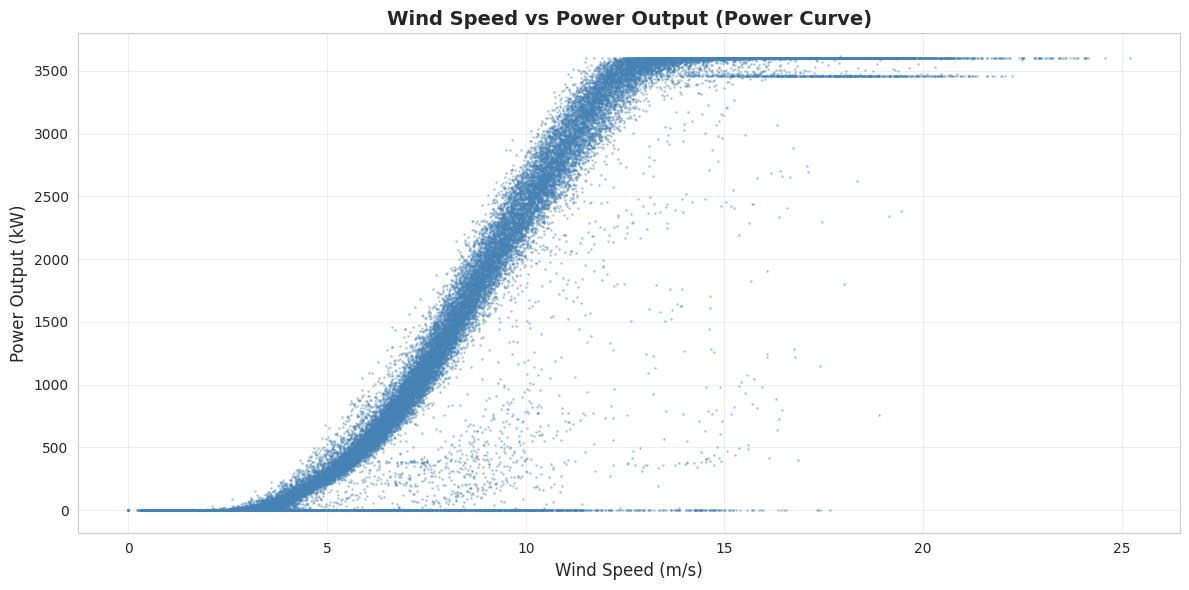

Generated Power Curve visualization


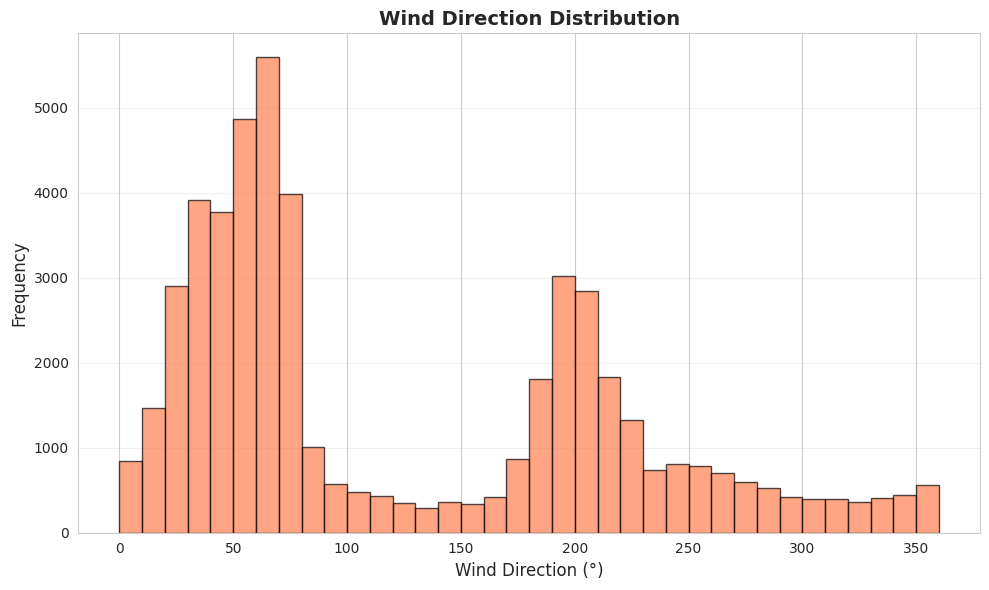

Generated Wind Direction distribution


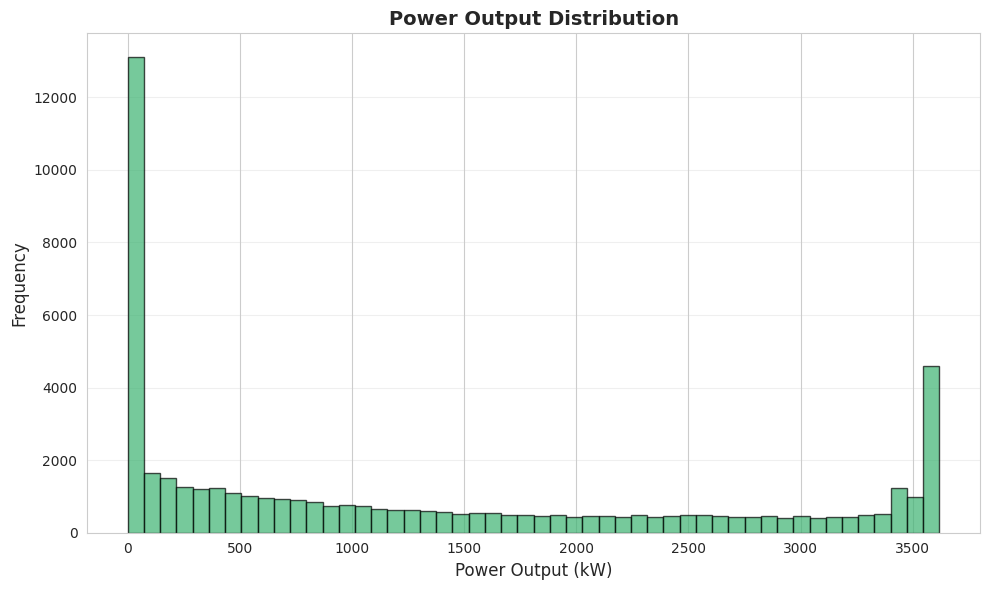

Generated Power Output distribution


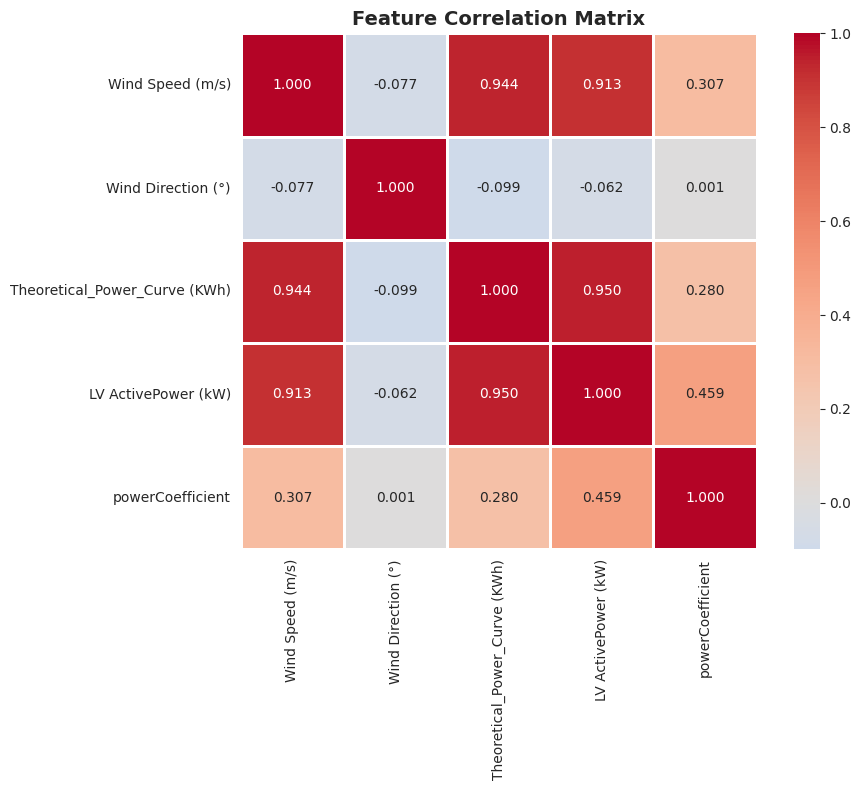

Generated Correlation Heatmap


In [20]:
#Data Analysis visualizations

#Wind Speed vs Power Output (Power Curve)
#expected pattern: Power increases with wind speed, then plateaus at rated capacity
plt.figure(figsize=(12, 6))
plt.scatter(
    cleanedDataFrame['Wind Speed (m/s)'],
    cleanedDataFrame['LV ActivePower (kW)'],
    s=1,  #Small point size since we have many data points
    alpha=0.3,  #Transparency to see density
    c='steelblue'
)
plt.title("Wind Speed vs Power Output (Power Curve)", fontsize=14, fontweight='bold')
plt.xlabel("Wind Speed (m/s)", fontsize=12)
plt.ylabel("Power Output (kW)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("Generated Power Curve visualization")

#Wind Direction Distribution, shows which wind direction are most common
plt.figure(figsize=(10, 6))
plt.hist(
    cleanedDataFrame['Wind Direction (°)'],
    bins=36,  # 36 bins equals 10 degrees per bin
    edgecolor='black',
    alpha=0.7,
    color='coral'
)
plt.title("Wind Direction Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Wind Direction (°)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
print("Generated Wind Direction distribution")

#Power Output Distribution, shows range and freq of power outputs
plt.figure(figsize=(10, 6))
plt.hist(
    cleanedDataFrame['LV ActivePower (kW)'],
    bins=50,
    edgecolor='black',
    alpha=0.7,
    color='mediumseagreen'
)
plt.title("Power Output Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Power Output (kW)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
print("Generated Power Output distribution")

#Correlation Heatmat
#Shows how different variables may relate
#Values close to 1 / -1 indicate strong relationships
correlationColumns = ['Wind Speed (m/s)', 'Wind Direction (°)',
                       'Theoretical_Power_Curve (KWh)', 'LV ActivePower (kW)',
                       'powerCoefficient']
correlationMatrix = cleanedDataFrame[correlationColumns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlationMatrix,
    annot=True,  # Show correlation values in cells
    fmt='.3f',  # Format to 3 decimal places
    cmap='coolwarm',  # Color scheme
    center=0,  # Center colormap at 0
    square=True,
    linewidths=1
)
plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print("Generated Correlation Heatmap")

In [21]:
#Data preparation for ML
#This involves selecting features, normalizing values, and splitting data

#Feature selection
#X represents input features (what we know), y represents target variable (what we predict)
featureColumns = ['Wind Speed (m/s)', 'Wind Direction (°)',
                  'Theoretical_Power_Curve (KWh)', 'windDirectionBin']
targetColumn = 'LV ActivePower (kW)'

inputFeatures = cleanedDataFrame[featureColumns]
targetVariable = cleanedDataFrame[targetColumn]

print(f"Selected {len(featureColumns)} input features")
print(f"  Features: {featureColumns}")
print(f"Target variable: {targetColumn}")

#Normalizatoin
featureScaler = StandardScaler()
scaledInputFeatures = featureScaler.fit_transform(inputFeatures)

# Convert back to DataFrame for easier handling
scaledInputFeatures = pd.DataFrame(
    scaledInputFeatures,
    columns=featureColumns,
    index=inputFeatures.index
)
print("Features normalized using StandardScaler")

#Train-Test Split (70/30)
xTrain, xTest, yTrain, yTest = train_test_split(
    scaledInputFeatures,
    targetVariable,
    test_size=0.3,  # 30% for testing
    random_state=42  # Ensures same split every time for reproducibility
)

print(f"\nData split complete:")
print(f"  Training set: {len(xTrain):,} samples ({len(xTrain)/len(cleanedDataFrame)*100:.1f}%)")
print(f"  Testing set:  {len(xTest):,} samples ({len(xTest)/len(cleanedDataFrame)*100:.1f}%)")

Selected 4 input features
  Features: ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)', 'windDirectionBin']
Target variable: LV ActivePower (kW)
Features normalized using StandardScaler

Data split complete:
  Training set: 35,331 samples (70.0%)
  Testing set:  15,142 samples (30.0%)


In [22]:
#Model training
#Train multiple ML models and compare their performance
#Each model learns patterns differently, so we test several to find the best

'''
Define models to test:
# 1. Linear Regression: Simple baseline model (assumes linear relationship)
# 2. Random Forest: Ensemble of decision trees (handles non-linearity well)
# 3. Gradient Boosting: Iteratively improves predictions (often achieves best performance)
'''

modelsToTrain = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=100,  # Number of trees
        random_state=42,
        n_jobs=-1  # Use all available CPU cores
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100,  # Number of boosting stages
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

#Dictionary to store results for each model
modelResults = {}

#Train each model and evaluate on test set
for modelName, modelObject in modelsToTrain.items():
    print(f"\nTraining {modelName}...")

    #Fit the model on training data
    modelObject.fit(xTrain, yTrain)

    #Make predictions on test set
    testPredictions = modelObject.predict(xTest)

    #Calculate performance metrics:
    #R-squared: How well model explains variance (0 to 1, higher is better)
    #RMSE: Average prediction error in original units
    #MAE: Average absolute prediction error
    r2Score = r2_score(yTest, testPredictions)
    rmseScore = np.sqrt(mean_squared_error(yTest, testPredictions))
    maeScore = mean_absolute_error(yTest, testPredictions)

    #Store results
    modelResults[modelName] = {
        "R-squared Score": r2Score,
        "RMSE (kW)": rmseScore,
        "MAE (kW)": maeScore,
        "Model Object": modelObject,
        "Predictions": testPredictions
    }

    print(f"  R-squared Score: {r2Score:.4f}")
    print(f"  RMSE: {rmseScore:.2f} kW")
    print(f"  MAE: {maeScore:.2f} kW")



Training Linear Regression...
  R-squared Score: 0.9090
  RMSE: 396.60 kW
  MAE: 186.36 kW

Training Random Forest...
  R-squared Score: 0.9051
  RMSE: 404.85 kW
  MAE: 168.66 kW

Training Gradient Boosting...
  R-squared Score: 0.9190
  RMSE: 374.02 kW
  MAE: 154.58 kW


In [23]:
#Model Eval and Comparsion
#Compare all models to select best performer

#Create comparison table
comparisonData = {
    name: {k: v for k, v in results.items()
           if k not in ['Model Object', 'Predictions']}
    for name, results in modelResults.items()
}
comparisonDataFrame = pd.DataFrame(comparisonData).T

print("\nPerformance Metrics Comparison:")
print(comparisonDataFrame)

#Identify best model (highest R-squared score)
bestModelName = comparisonDataFrame['R-squared Score'].idxmax()
bestModelObject = modelResults[bestModelName]['Model Object']
bestModelPredictions = modelResults[bestModelName]['Predictions']

print(f"\nBest performing model: {bestModelName}")
print(f"   R-squared Score: {modelResults[bestModelName]['R-squared Score']:.4f}")


Performance Metrics Comparison:
                   R-squared Score   RMSE (kW)    MAE (kW)
Linear Regression         0.908956  396.601475  186.360435
Random Forest             0.905128  404.853013  168.663663
Gradient Boosting         0.919028  374.020656  154.582188

Best performing model: Gradient Boosting
   R-squared Score: 0.9190


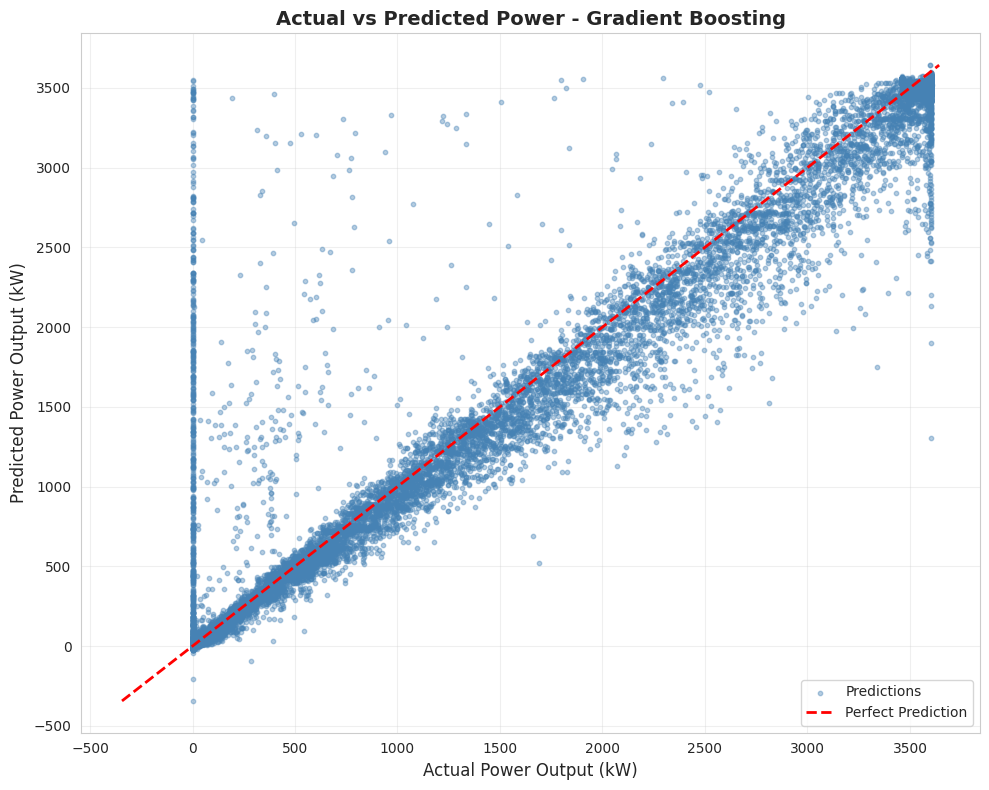

Generated Actual vs Predicted plot


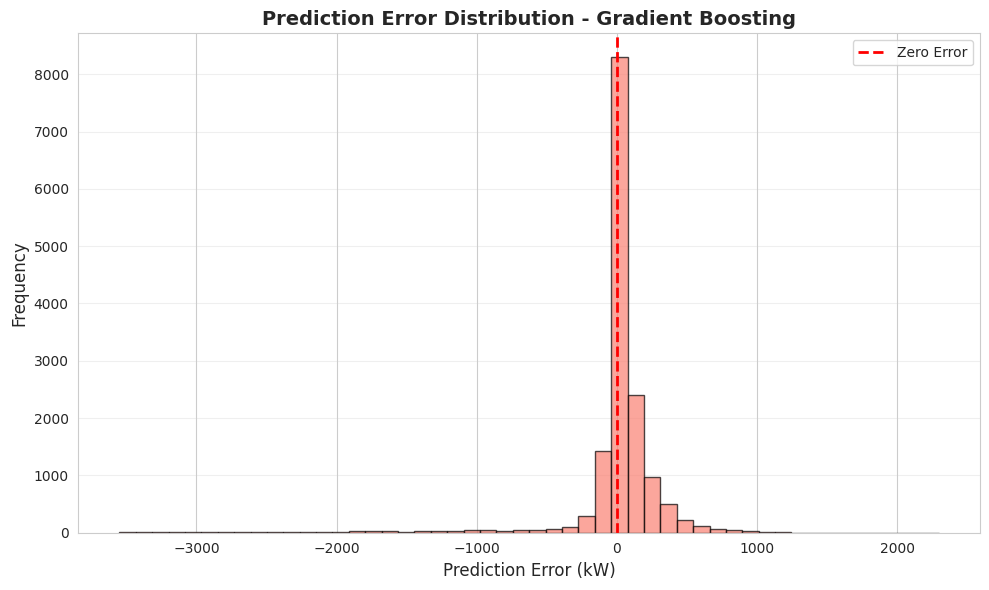

Generated Residual Error Distribution


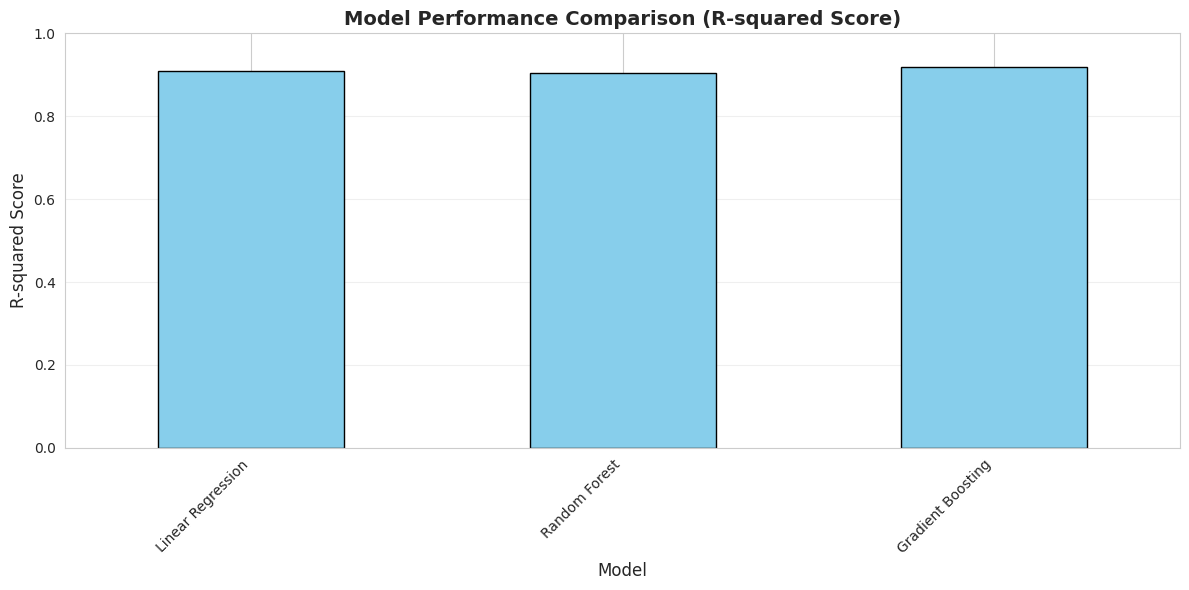

Generated Model Comparison chart


In [24]:
#Result Visualization, creating plots to show model perfomance

#Actual Vs Predicted power scatter plot
# Perfect predictions would lie on the red diagonal line
plt.figure(figsize=(10, 8))
plt.scatter(
    yTest,
    bestModelPredictions,
    alpha=0.4,
    s=10,
    c='steelblue',
    label='Predictions'
)

#Add perfect prediction line (y equals x)
minValue = min(yTest.min(), bestModelPredictions.min())
maxValue = max(yTest.max(), bestModelPredictions.max())
plt.plot([minValue, maxValue], [minValue, maxValue],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel("Actual Power Output (kW)", fontsize=12)
plt.ylabel("Predicted Power Output (kW)", fontsize=12)
plt.title(f"Actual vs Predicted Power - {bestModelName}",
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("Generated Actual vs Predicted plot")

#Residual Error Distribution, Residual equal preduction errors
#should be centered around 0 with normal distribution for a good model
residuals = yTest - bestModelPredictions

plt.figure(figsize=(10, 6))
plt.hist(
    residuals,
    bins=50,
    edgecolor='black',
    alpha=0.7,
    color='salmon'
)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title(f"Prediction Error Distribution - {bestModelName}",
          fontsize=14, fontweight='bold')
plt.xlabel("Prediction Error (kW)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
print("Generated Residual Error Distribution")

#Model Comparision Bar Chart
plt.figure(figsize=(12, 6))
comparisonDataFrame['R-squared Score'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Model Performance Comparison (R-squared Score)", fontsize=14, fontweight='bold')
plt.xlabel("Model", fontsize=12)
plt.ylabel("R-squared Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
print("Generated Model Comparison chart")


Feature Importance Rankings:
                         Feature  Importance
0               Wind Speed (m/s)    0.574727
2  Theoretical_Power_Curve (KWh)    0.408727
1             Wind Direction (°)    0.016424
3               windDirectionBin    0.000122


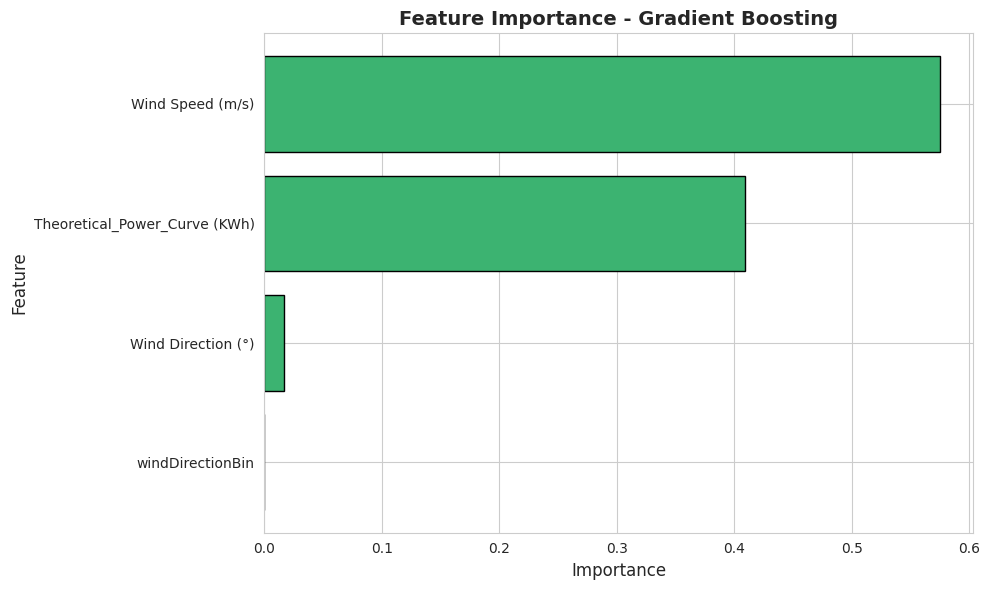

Generated Feature Importance plot


In [25]:
#Feature importance analysis

#Check if best model supports feature importance
if hasattr(bestModelObject, 'feature_importances_'):
    featureImportances = pd.DataFrame({
        'Feature': featureColumns,
        'Importance': bestModelObject.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importance Rankings:")
    print(featureImportances)

    #Feature importance bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(featureImportances['Feature'], featureImportances['Importance'],
             color='mediumseagreen', edgecolor='black')
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.title(f"Feature Importance - {bestModelName}",
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.tight_layout()
    plt.show()
    print("Generated Feature Importance plot")
else:
    print(f"Note: {bestModelName} does not provide feature importance scores")

In [26]:
# SECTION 12: FINAL SUMMARY & CONCLUSIONS
# Compile all results and key findings from the analysis

print("\nPROJECT SUMMARY & KEY FINDINGS")

print(f"""
PROJECT COMPLETED SUCCESSFULLY

DATASET STATISTICS:
   Total observations processed: {len(cleanedDataFrame):,}
   Features used for prediction: {len(featureColumns)}
   Data quality: {(len(cleanedDataFrame)/initialRowCount)*100:.1f}% retention after cleaning

MODEL PERFORMANCE:
   Best model: {bestModelName}
   R-squared Score: {modelResults[bestModelName]['R-squared Score']:.4f}
     (Explains {modelResults[bestModelName]['R-squared Score']*100:.2f}% of variance)
   Average prediction error (RMSE): {modelResults[bestModelName]['RMSE (kW)']:.2f} kW
   Average absolute error (MAE): {modelResults[bestModelName]['MAE (kW)']:.2f} kW
   """)


PROJECT SUMMARY & KEY FINDINGS

PROJECT COMPLETED SUCCESSFULLY

DATASET STATISTICS:
   Total observations processed: 50,473
   Features used for prediction: 4
   Data quality: 99.9% retention after cleaning

MODEL PERFORMANCE:
   Best model: Gradient Boosting
   R-squared Score: 0.9190 
     (Explains 91.90% of variance)
   Average prediction error (RMSE): 374.02 kW
   Average absolute error (MAE): 154.58 kW
   
